In [1]:
from chase.base import *
from chase.utils import *
from chase.fit import *
import pickle
from mypy.explib.frey2014 import frey2014
pd.set_option('display.max_colwidth', 100)
sns.set_style("whitegrid")

FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/ssDFE/ssDFE_v3/figures/'

In [2]:
data = pd.read_csv('data/frey_data.csv', index_col=0)
problems = {gid: frey2014.get_options(gid) for gid in data.problem.unique()}

In [5]:
data.head()

,subject,problem,group,choice,samplesize
0,1,S1G1,0,0,12
1,1,S2G1,0,1,10
2,1,S3G1,0,0,10
3,1,S4G1,0,0,10
4,1,S5G1,0,0,10


In [7]:
data.groupby('subject').apply(lambda d: np.std(d.samplesize))

subject
1       1.184987
2      14.936192
3       7.612050
4       3.706723
5       8.106741
6      15.763393
7      59.231999
8      32.843488
9      10.633555
12     34.838553
13      8.509177
15      6.588003
16     12.010689
17     14.807189
18     15.019356
20      6.062727
21     10.068952
22     11.249710
23      3.868205
24      3.717699
25      4.951460
26     20.437329
27      6.976637
28     14.605100
29     14.881543
30     11.319789
31     11.066717
32     15.144565
33      3.798869
34      3.845596
         ...    
106    21.146326
109    17.972280
110     2.028251
111     3.602956
112     6.379797
113     6.604075
114    21.025818
115    14.929896
116     6.560420
117    11.107880
118     9.398302
119     8.516973
120     8.214148
121    20.149385
122     9.495583
123    12.759078
124     3.983526
125    23.629282
126    16.472556
127    22.929832
128    20.579980
129    11.117869
130     2.485217
131    15.164674
132    11.591228
133     8.885604
134     6.523147
135   

In [4]:
# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 50],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'mu': [0., np.inf, 10.],
        'sc': [0., np.inf, 1.],
        'p_stop': [0, 1, .5]}

# parameters that are set to fixed values 
FIXED = {'c': 0.5,
         'theta': 30}
FIXED_OPT = {'c': 0.5}

OUTDIR = 'chase_fitresults_frey_individual'

PARSETS_GEOM = [['p_stop', 'p_stay', 'tau'],
                ['p_stop', 'p_stay', 'tau', 'prelec_gamma'],
                ['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                ['p_stop', 'p_stay', 'tau', 'pow_gain'],
               ]

PARSETS_NORMAL = [['mu', 'sc', 'p_stay', 'tau'],
                  ['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma'],
                  ['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                  ['mu', 'sc', 'p_stay', 'tau', 'pow_gain'],
                  ]

PARSETS_OPT = [['theta', 'p_stay', 'tau'],
               ['theta', 'p_stay', 'tau', 'prelec_gamma'],
               ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
               ['theta', 'p_stay', 'tau', 'pow_gain'],
              ]

COMPARISON_RESULTS = {}

def model_table(sid, force=False):
    if sid not in COMPARISON_RESULTS or force:
        COMPARISON_RESULTS[sid] = pd.read_csv(OUTDIR+'/modelcomparison_subj=%s.csv' % sid, index_col=0)
    return COMPARISON_RESULTS[sid]

In [4]:
with open('data/frey_switchrates.pkl', 'r') as f:
    emp_p_switch = pickle.load(f)

In [68]:
data.subject.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  12,  13,  15,  16,
        17,  18,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39, 100, 101, 102, 103,
       104, 106, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137])

In [34]:
for sid in data.subject.unique():

    results = pd.DataFrame([], columns=['sim_id', 'stoprule', 'weighting', 'switching',
                                        'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                        'theta', 'p_stop', 'mu', 'sc', 
                                        'prelec_gamma', 'prelec_elevation',
                                        'pow_gain', 'w_loss'])

    for i, parset in enumerate(PARSETS_OPT):
        model_id = 'frey_individual_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED_OPT, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'optional'
        results.loc[results.shape[0]-1,'switching'] = False
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    for i, parset in enumerate(PARSETS_GEOM):
        model_id = 'frey_individual_planned_geom_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'geom'
        results.loc[results.shape[0]-1,'switching'] = False
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    for i, parset in enumerate(PARSETS_NORMAL):
        model_id = 'frey_individual_planned_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'normal'
        results.loc[results.shape[0]-1,'switching'] = False
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    """
    # switching, optional stopping
    for i, parset in enumerate(PARSETS_OPT):
        model_id = 'frey_individual_switching_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        fixed = deepcopy(FIXED_OPT)
        fixed['p_switch'] = emp_p_switch[sid]
        b = best_result(model_id, fixed, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'optional'
        results.loc[results.shape[0]-1,'switching'] = True
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]

    # switching, planned stopping
    for i, parset in enumerate(PARSETS_NORMAL):
        model_id = 'frey_individual_switching_planned_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        fixed = deepcopy(FIXED)
        fixed['p_switch'] = emp_p_switch[sid]
        b = best_result(model_id, fixed, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'normal'
        results.loc[results.shape[0]-1,'switching'] = True
        results.loc[results.shape[0]-1,'weighting'] = ['none', 'prob1', 'prob2', 'value1', 'value2'][i]
    """
    results.loc[results.switching==0,'switching'] = False
    results.sort('bic', inplace=True)
    
    w = np.exp(-.5 * (results.bic - results.iloc[0].bic)).values
    w = w/w.sum()
    results['W_bic'] = w

    results.to_csv(OUTDIR+'/modelcomparison_subj=%s.csv' % sid)

In [47]:
model_table(33, force=True)

,sim_id,stoprule,weighting,switching,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss,W_bic
0,"frey_individual_subj=33(p_stay,tau,theta|c=0.5)",optional,none,False,3,84,283.247899,579.788248,0.001952,1.082212e-05,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"frey_individual_subj=33(p_stay,pow_gain,tau,theta|c=0.5)",optional,value1,False,4,84,283.251332,584.225931,0.001950,2.006453e-07,4,NaN,NaN,NaN,NaN,NaN,1.002611,NaN,NaN
15,"frey_individual_switching_subj=33(p_stay,pow_gain,tau,theta|c=0.5,p_switch=0.999)",optional,value1,True,4,84,285.852175,589.427617,0.001931,6.299066e-07,4,NaN,NaN,NaN,NaN,NaN,3.044151,NaN,NaN
13,"frey_individual_switching_subj=33(p_stay,prelec_gamma,tau,theta|c=0.5,p_switch=0.999)",optional,prob1,True,4,84,287.417863,592.558992,0.001411,4.204295e-03,4,NaN,NaN,NaN,0.000017,NaN,NaN,NaN,NaN
14,"frey_individual_switching_subj=33(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5,p_switch=...",optional,prob2,True,5,84,286.884825,595.923735,0.001899,1.027303e-03,4,NaN,NaN,NaN,0.000015,3.504993,NaN,NaN,NaN
8,"frey_individual_planned_subj=33(mu,p_stay,sc,tau|c=0.5,theta=30)",normal,none,False,4,84,289.151723,596.026712,0.629895,2.207842e-06,30,NaN,12.085441,3.803611,NaN,NaN,NaN,NaN,NaN
16,"frey_individual_switching_planned_subj=33(mu,p_stay,sc,tau|c=0.5,p_switch=0.999,theta=30)",normal,none,True,4,84,289.453931,596.631129,0.987260,6.305295e-02,30,NaN,12.085488,3.803560,NaN,NaN,NaN,NaN,NaN
2,"frey_individual_subj=33(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5)",optional,prob2,False,5,84,288.063581,598.281246,0.001203,6.423292e-03,4,NaN,NaN,NaN,0.158068,2.990050,NaN,NaN,NaN
9,"frey_individual_planned_subj=33(mu,p_stay,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob1,False,5,84,288.925649,600.005382,0.608847,4.408259e-01,30,NaN,12.084813,3.802057,1.333914,NaN,NaN,NaN,NaN
11,"frey_individual_planned_subj=33(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)",normal,value1,False,5,84,289.147576,600.449236,0.636678,6.264206e-06,30,NaN,12.085441,3.803611,NaN,NaN,0.970984,NaN,NaN


In [5]:
def lookup_bic(fitdf, switching, stoprule, weighting):
    return fitdf[(fitdf.switching==switching) & 
                 (fitdf.stoprule==stoprule) &
                 (fitdf.weighting==weighting)].bic.values[0]

In [ ]:
1, 2, 3, 4, 5, 6, 8, 9, 13, 15, 16, 17, 18, 20, 21, 22, \
            23,  24,  25,  26,  27,  28,  29,  30,
            31,  32,  33,  34,  35,  36,  37,  38, 39

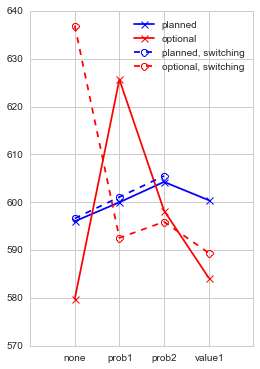

In [46]:
fitdf = model_table(33, force=True)

cols = ['blue', 'red']
styl = ['-x', '--o']

fig, ax = plt.subplots(figsize=(4,6))
ax.plot([lookup_bic(fitdf, False, 'normal', 'none'),
         lookup_bic(fitdf, False, 'normal', 'prob1'),
         lookup_bic(fitdf, False, 'normal', 'prob2'),
         lookup_bic(fitdf, False, 'normal', 'value1')], 
        styl[0], color=cols[0], label='planned',
        markerfacecolor=cols[0], markeredgecolor=cols[0], markeredgewidth=1)
ax.plot([lookup_bic(fitdf, False, 'optional', 'none'),
         lookup_bic(fitdf, False, 'optional', 'prob1'),
         lookup_bic(fitdf, False, 'optional', 'prob2'),
         lookup_bic(fitdf, False, 'optional', 'value1')], 
        styl[0], color=cols[1], label='optional', 
        markerfacecolor=cols[1], markeredgecolor=cols[1], markeredgewidth=1)
ax.plot([lookup_bic(fitdf, True, 'normal', 'none'),
         lookup_bic(fitdf, True, 'normal', 'prob1'),
         lookup_bic(fitdf, True, 'normal', 'prob2'),
         lookup_bic(fitdf, True, 'normal', 'value1')], 
        styl[1], color=cols[0], label='planned, switching',
        markerfacecolor='none', markeredgecolor=cols[0], markeredgewidth=1)
ax.plot([lookup_bic(fitdf, True, 'optional', 'none'),
         lookup_bic(fitdf, True, 'optional', 'prob1'),
         lookup_bic(fitdf, True, 'optional', 'prob2'),
         lookup_bic(fitdf, True, 'optional', 'value1')], 
        styl[1], color=cols[1], label='optional, switching',
        markerfacecolor='none', markeredgecolor=cols[1], markeredgewidth=1)
ax.legend()

ax.set_xticks(range(4))
ax.set_xticklabels(['none', 'prob1', 'prob2', 'value1'])
ax.set_xlim(-1, 4)
plt.show()

# Model weights

In [35]:
from mypy.viz import tableau20

In [36]:
stoprules = ['Optional', 'Normal', 'Geometric']
weighting = ['Value(2)', 'Value(1)', 'Prob(2)', 'Prob(1)', 'None']


col = []
labs = []
ind = [0, 4, 2]
for i in range(3):
    for j in range(5):
        col.append(.2 + np.array(tableau20[ind[i]]) * (.15 * (j+1)))
        labs.append('%s, %s' % (stoprules[i], weighting[j]))

In [37]:
arr = []
for j, sid in enumerate(data.subject.unique()):
    tab = model_table(sid, force=True)[['stoprule', 'weighting', 'W_bic']]
    arr.append([sid, tab[tab.stoprule=='optional'].W_bic.sum()])
arr = np.array(arr)

In [38]:
srted = np.array(arr[np.argsort(arr[:,1])][:,0], int)

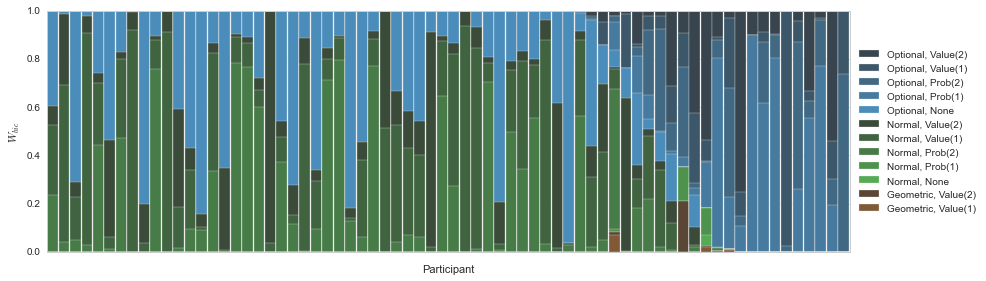

In [39]:
fig, ax = plt.subplots(figsize=(12,4))

for j, sid in enumerate(srted):

    tab = model_table(sid, force=True)[['stoprule', 'weighting', 'W_bic']]
    w = tab.sort(['stoprule', 'weighting']).W_bic.values
    
    for i, w_i in enumerate(np.cumsum(w)[::-1]):
        if j==0:
            ax.bar(j, w_i, color=col[i], alpha=1, width=.95, label=labs[i])
        else:
            ax.bar(j, w_i, color=col[i], alpha=1, width=.95)

ax.legend(loc='center left', bbox_to_anchor=(1, .5))
ax.set_ylim(0, 1)
ax.set_ylabel(r'$W_{bic}$')
ax.set_xlabel('Participant')
ax.set_xticklabels([])
plt.tight_layout()
plt.show()
#fig.savefig(FIGDEST + 'frey_model_weights.pdf', bbox_inches='tight')

In [46]:
labels = ['planned, prob', 'planned, value', 'optional, value', 'optional, prob']
col = [(1, 0, 0), (1, .6, .5), (.5, .6, 1), 'blue']
fig, ax = plt.subplots(figsize=(8,4))
for i, arr in enumerate(np.cumsum(w_srt, axis=1).transpose()[::-1]):
    #print arrb
    plt.bar(range(len(arr)), arr, color=col[i], alpha=1, width=.95, label=labels[i])
ax.set_ylim(0, 1)
ax.set_xlim(0, len(w_srt))
ax.set_xlabel('Participant')
ax.set_ylabel('Model weights')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
fig.savefig(FIGDEST+'frey_individual_modelweights.pdf', bbox_inches='tight')

3    8.802384e-68
4    1.365643e-67
5    1.182303e-68
6    1.167832e-01
7    8.789292e-01
8    4.287561e-03
0    1.435743e-61
1    8.768537e-60
2    2.730192e-61
Name: W_bic, dtype: float64

# Best-fit model

Looking good: 
1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 100, 101, 102, 103, 104, 106, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131 132, 133, 134, 135, 136, 137

Not so good: 126

Pattern:

- U-shaped: 4, 18, 20?, 

- Inverted-U: 
1, 2, 6, 8, 12, 13, 16, 23, 27, 30?, 31, 32, 34, 
35, 39, 100, 101, 102, 103, 104, 113, 114, 117, 118,
119, 120, 121, 122, 123, 124, 126, 128, 131, 132, 134, 
135, 136, 137

- Neither: 3, 7, 9, 15, 17, 21, 22, 24, 26, 28, 29, 33, 36, 37,
106, 109, 111, 112, 115, 116, 125, 127, 129, 130, 133



In [81]:
model_table(29)

,sim_id,stoprule,weighting,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss,W_bic
6,"frey_individual_planned_subj=29(mu,p_stay,sc,tau|c=0.5,theta=30)",normal,none,4,84,386.513628,790.750523,4.622154e-11,8.278388e-11,30,NaN,8.260355,21.349874,NaN,NaN,NaN,NaN,0.734790
0,"frey_individual_subj=29(p_stay,tau,theta|c=0.5)",optional,none,3,84,390.332035,793.956520,3.386315e-01,5.488692e-01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.147907
3,"frey_individual_planned_geom_subj=29(p_stay,p_stop,tau|c=0.5,theta=30)",geom,none,3,84,390.859946,795.012343,1.263479e-04,7.222179e-01,30,0.049218,NaN,NaN,NaN,NaN,NaN,NaN,0.087241
7,"frey_individual_planned_subj=29(mu,p_stay,prelec_elevation,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob,6,84,386.270399,799.125699,2.379533e-09,1.589875e-08,30,NaN,8.260355,21.349874,1.091224,1.044273,NaN,NaN,0.011156
8,"frey_individual_planned_subj=29(mu,p_stay,pow_gain,sc,tau,w_loss|c=0.5,theta=30)",normal,value,6,84,386.367126,799.319153,4.622154e-11,8.641030e-10,30,NaN,8.260355,21.349874,NaN,NaN,0.905866,11.351716,0.010128
1,"frey_individual_subj=29(p_stay,prelec_elevation,prelec_gamma,tau,theta|c=0.5)",optional,prob,5,84,389.751402,801.656888,8.208205e-01,2.041095e-01,2,NaN,NaN,NaN,1.246827,1.141910,NaN,NaN,0.003147
2,"frey_individual_subj=29(p_stay,pow_gain,tau,theta,w_loss|c=0.5)",optional,value,5,84,389.883984,801.922053,3.420607e-01,5.510208e-01,4,NaN,NaN,NaN,NaN,NaN,0.836498,1.196585,0.002756
5,"frey_individual_planned_geom_subj=29(p_stay,p_stop,pow_gain,tau,w_loss|c=0.5,theta=30)",geom,value,5,84,390.421498,802.997079,3.437289e-07,2.856374e-01,30,0.049180,NaN,NaN,NaN,NaN,0.906463,2.329605,0.001610
4,"frey_individual_planned_geom_subj=29(p_stay,p_stop,prelec_elevation,prelec_gamma,tau|c=0.5,theta...",geom,prob,5,84,390.662613,803.479310,9.255841e-07,7.748588e-01,30,0.049210,NaN,NaN,1.486918,0.807103,NaN,NaN,0.001265


In [6]:
sid = 137
model_ind = 0
tab = model_table(sid)
stoprule, weighting = tab.iloc[model_ind][['stoprule', 'weighting']].values
p_ind = ['none', 'prob1', 'prob2', 'value1', 'value2'].index(weighting)
print stoprule
print weighting


if stoprule == 'optional':
    model_id = 'frey_individual_subj=%s' % sid
    fixed = FIXED_OPT
    fitting = {p: PARS[p] for p in PARSETS_OPT[p_ind]}
    
    # initialize the model
    m = CHASEModel(drift='cpt', startdist='laplace', problems=problems)

elif stoprule == 'geom':
    model_id = 'frey_individual_planned_geom_subj=%s' % sid
    fixed = FIXED
    fitting = {p: PARS[p] for p in PARSETS_GEOM[p_ind]}
    
    # initialize the model
    m = CHASEAlternateStoppingModel(drift='cpt',
                                    startdist='laplace',
                                    stoprule='geometric',
                                    problems=problems)

elif stoprule == 'normal':
    model_id = 'frey_individual_planned_subj=%s' % sid
    fixed = FIXED
    fitting = {p: PARS[p] for p in PARSETS_NORMAL[p_ind]}
    
    # initialize the model
    m = CHASEAlternateStoppingModel(drift='cpt',
                                    startdist='laplace',
                                    stoprule='truncatednormal',
                                    problems=problems)

pred = predict_from_result(m, problems, model_id, fixed=fixed, fitting=fitting, outdir=OUTDIR, max_T=200)

normal
value1


In [10]:
observed_samplesize = data[(data.subject==sid)].samplesize.values - 1
predicted_samplesize = []

observed = []
predicted = []

for gid in frey2014.gamble_lab_srt:
    obs = data[(data.subject==sid) & (data.problem==gid)]
    if obs.shape[0] > 0:
        choice, ss = obs[['choice', 'samplesize']].values[0]
        observed.append(choice)
        
        if stoprule == 'optional':
            predicted.append(pred[gid]['p_resp'][1])
            predicted_samplesize.append(pred[gid]['p_stop_cond'][:,0]*pred[gid]['p_resp'][0] + pred[gid]['p_stop_cond'][:,1]*pred[gid]['p_resp'][1])
        else:
            predicted.append(pred[gid]['p_resp_t'][ss - 1][1])
            predicted_samplesize.append(pred[gid]['p_stop'])
    else:
        observed.append(np.nan)
        predicted.append(np.nan)

observed_by_type = [np.nanmean(observed[:21]),
                    np.nanmean(observed[21:42]),
                    np.nanmean(observed[42:63]),
                    np.nanmean(observed[63:])]

predicted_by_type = [np.nanmean(predicted[:21]),
                     np.nanmean(predicted[21:42]),
                     np.nanmean(predicted[42:63]),
                     np.nanmean(predicted[63:])]

observed = np.array(observed)
predicted = np.array(predicted)

choseL = np.arange(len(observed))[np.array(observed)==0]
choseH = np.arange(len(observed))[np.array(observed)==1]

In [15]:
np.mean((observed - predicted)**2)

0.21864816245466834

In [17]:
observed_samplesize

array([20, 12, 18, 17,  0, 14, 22, 13, 17, 12, 11, 13, 15, 13, 12, 13, 24,
       12, 16, 10, 10, 17,  8, 15, 18,  0,  8, 25, 14, 15, 17, 14, 14, 14,
       25, 15, 13, 17, 19, 20,  9,  8, 27, 10, 10, 12,  0,  0, 19, 15, 14,
       18, 16, 21, 18, 11, 19, 15, 19, 21, 11, 12, 13, 26, 15, 14, 12,  0,
       16, 27, 14, 30, 11, 19, 12, 19, 15, 14, 19, 23, 25, 17, 15,  8])

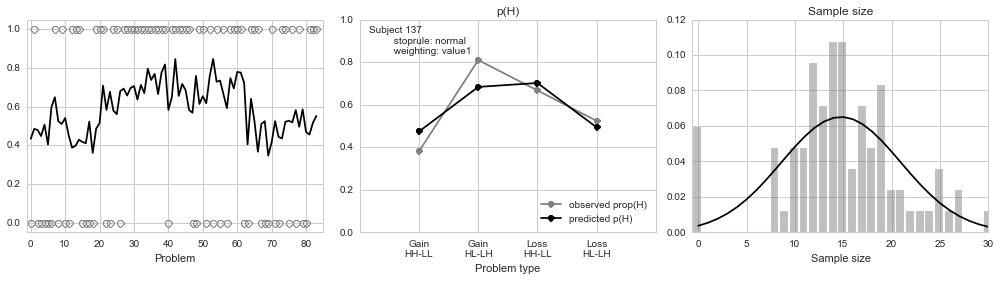

In [387]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

axi = ax[0]
axi.plot(choseH, np.ones(len(choseH)), 'o', color='gray', 
        markerfacecolor='none', markeredgecolor='gray', markeredgewidth=1)
axi.plot(choseL, np.zeros(len(choseL)), 'o', color='gray', 
        markerfacecolor='none', markeredgecolor='gray', markeredgewidth=1)
axi.plot(predicted, color='black')
axi.set_ylim(-.05,1.05)
axi.set_xlim(-1, 85)
axi.set_xlabel('Problem')

axi = ax[1]
axi.plot(observed_by_type, '-o', color='gray', label='observed prop(H)')
axi.plot(predicted_by_type, '-o', color='black', label='predicted p(H)')
axi.set_ylim(0, 1)
axi.set_xlim(-1, 4)
axi.set_xticks(range(4))
axi.set_xlabel('Problem type')
axi.set_xticklabels(['Gain\nHH-LL', 'Gain\nHL-LH', 'Loss\nHH-LL', 'Loss\nHL-LH'])
axi.set_title('p(H)')
axi.legend(loc='lower right')

axi = ax[2]
bc = np.bincount(observed_samplesize)
bc = bc / float(bc.sum())
axi.bar(np.arange(bc.size) - .5, bc, color='gray', alpha=.5)
axi.plot(np.array(predicted_samplesize).mean(axis=0),
         color='black')
axi.set_title('Sample size')
axi.set_xlim(-.6, observed_samplesize.max())
axi.set_xlabel('Sample size')

txt = '''Subject %s
         stoprule: %s
         weighting: %s''' % (sid, stoprule, weighting)
fig.text(.37, .8, txt)

plt.tight_layout()
plt.show()
fig.savefig(OUTDIR+'/bestmodel_subj=%s.pdf' % sid, bbox_inches='tight')

# Overall comparison

In [40]:
compdf = pd.DataFrame([], columns=['sid', 'cond', 'sim_id', 'stoprule', 'weighting', 
                                      'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                      'theta', 'p_stop', 'mu', 'sc', 
                                      'prelec_gamma', 'prelec_elevation',
                                      'pow_gain', 'w_loss'])
for sid in data.subject.unique():
    tab = model_table(sid, force=True)
    #tab = tab[tab.weighting!='none']
    compdf.loc[compdf.shape[0]] = tab.iloc[0]
    compdf.loc[compdf.shape[0]-1,'sid'] = sid
    compdf.loc[compdf.shape[0]-1,'cond'] = frey2014.condition(sid)

In [41]:
compdf

,sid,cond,sim_id,stoprule,weighting,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss
0,1,old,"frey_individual_planned_subj=1(mu,p_stay,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob1,5,84,165.452175,353.058434,9.498133e-01,8.268857e-03,30,NaN,9.707253,0.652966,5.000000,NaN,NaN,NaN
1,2,old,"frey_individual_subj=2(p_stay,prelec_gamma,tau,theta|c=0.5)",optional,prob1,4,80,342.274116,702.076338,7.805418e-01,7.895243e-01,2,NaN,NaN,NaN,1.992813,NaN,NaN,NaN
2,3,old,"frey_individual_planned_subj=3(mu,p_stay,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob1,5,84,342.668929,707.491942,3.553670e-08,6.444832e-01,30,NaN,20.303897,7.738908,1.436748,NaN,NaN,NaN
3,4,old,"frey_individual_planned_subj=4(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)",normal,value1,5,84,277.423819,577.001722,5.039102e-01,1.150631e-07,30,NaN,13.712824,3.698612,NaN,NaN,5.033732,NaN
4,5,old,"frey_individual_planned_subj=5(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)",normal,value1,5,84,350.261851,722.677785,8.057516e-01,3.512040e-08,30,NaN,20.418267,8.306097,NaN,NaN,0.245704,NaN
5,6,old,"frey_individual_planned_subj=6(mu,p_stay,prelec_gamma,sc,tau|c=0.5,theta=30)",normal,prob1,5,84,399.686340,821.526764,9.844097e-01,5.163352e-03,30,NaN,23.202746,18.968960,5.000000,NaN,NaN,NaN
6,7,old,"frey_individual_subj=7(p_stay,prelec_gamma,tau,theta|c=0.5)",optional,prob1,4,83,479.358365,976.392093,6.279585e-01,2.007334e-01,5,NaN,NaN,NaN,0.626593,NaN,NaN,NaN
7,8,old,"frey_individual_planned_subj=8(mu,p_stay,pow_gain,sc,tau|c=0.5,theta=30)",normal,value1,5,83,448.728692,919.551588,3.040561e-01,1.208560e-01,30,NaN,36.006194,42.504818,NaN,NaN,0.607023,NaN
8,9,old,"frey_individual_planned_subj=9(mu,p_stay,sc,tau|c=0.5,theta=30)",normal,none,4,80,353.158235,723.844576,9.491233e-01,6.177176e-01,30,NaN,16.008200,12.643947,NaN,NaN,NaN,NaN
9,12,old,"frey_individual_subj=12(p_stay,prelec_gamma,tau,theta|c=0.5)",optional,prob1,4,83,428.642143,874.959648,3.142063e-01,5.639029e-09,7,NaN,NaN,NaN,1.523975,NaN,NaN,NaN


In [6]:
18/70.

0.2571428571428571

In [42]:
compdf['stoprule'].value_counts()

normal      52
optional    18
dtype: int64

In [43]:
print 52/70.
print 18/70.

0.742857142857
0.257142857143


In [44]:
compdf['weighting'].value_counts()

value1    24
none      21
prob1     20
prob2      5
dtype: int64

In [49]:
for stoprule in ['normal', 'optional']:
    for weighting in ['none', 'prob1', 'prob2', 'value1', 'value2']:
        sel = compdf[(compdf.stoprule==stoprule) & (compdf.weighting==weighting)]
        print stoprule, weighting
        print np.round(sel[['p_stay', 'tau', 'theta', 'p_stop', 'mu', 'sc', 
                   'prelec_gamma', 'prelec_elevation', 'pow_gain']].describe(percentiles=[]), 2)

normal none
       p_stay    tau  theta  p_stop     mu     sc  prelec_gamma  \
count   15.00  15.00     15       0  15.00  15.00             0   
mean     0.43   0.30     30     NaN  21.96  11.52           NaN   
std      0.42   0.35      0     NaN  16.94   7.96           NaN   
min      0.00   0.00     30     NaN   6.33   2.52           NaN   
50%      0.38   0.06     30     NaN  15.97   9.91           NaN   
max      1.00   1.00     30     NaN  61.52  25.45           NaN   

       prelec_elevation  pow_gain  
count                 0         0  
mean                NaN       NaN  
std                 NaN       NaN  
min                 NaN       NaN  
50%                 NaN       NaN  
max                 NaN       NaN  
normal prob1
       p_stay    tau  theta  p_stop     mu     sc  prelec_gamma  \
count   14.00  14.00     14       0  14.00  14.00         14.00   
mean     0.28   0.32     30     NaN  28.78  12.11          2.19   
std      0.35   0.31      0     NaN  16.19   6.47   

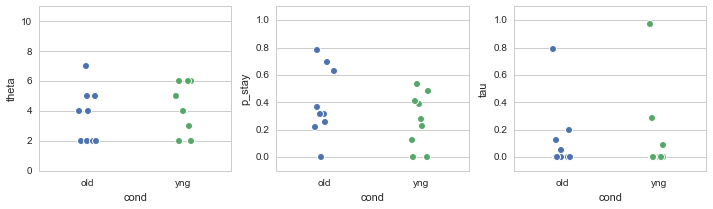

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
sns.stripplot(x='cond', y='theta', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[0])
sns.stripplot(x='cond', y='p_stay', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[1])
sns.stripplot(x='cond', y='tau', data=compdf[compdf.stoprule=='optional'], jitter=True, ax=ax[2])
ax[0].set_ylim(0, 11)
ax[1].set_ylim(-.1, 1.1)
ax[2].set_ylim(-.1, 1.1)
plt.tight_layout()
plt.show()

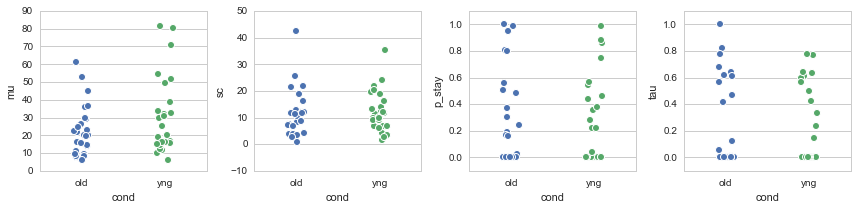

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))
sns.stripplot(x='cond', y='mu', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[0])
sns.stripplot(x='cond', y='sc', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[1])
sns.stripplot(x='cond', y='p_stay', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[2])
sns.stripplot(x='cond', y='tau', data=compdf[compdf.stoprule=='normal'], jitter=True, ax=ax[3])
ax[2].set_ylim(-.1, 1.1)
ax[3].set_ylim(-.1, 1.1)
plt.tight_layout()
plt.show()

In [11]:
from chase.cpt import value_fnc

def prelec(p, prelec_elevation, prelec_gamma):
    return np.exp(-prelec_elevation * ((-np.log(p)) ** prelec_gamma))

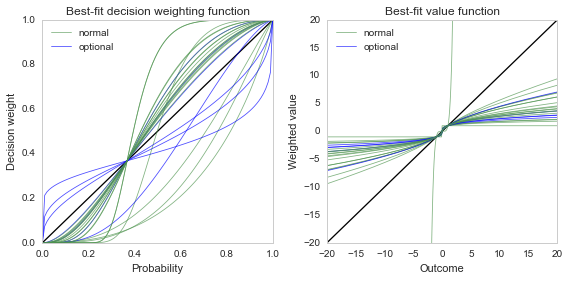

In [50]:
#col = {'old': 'red', 'yng': 'blue'}
#col = {'old': 'gray', 'yng': 'gray'}
col = {'normal': [ 0.30352941,  0.57647059,  0.30352941], 'optional': 'blue'}
al = .7
lw = .8

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

p = np.arange(0, 1.01, .01)
axi = ax[0]
axi.plot([0, 1], [0, 1], color='black', alpha=1, linewidth=1.3)

for i, row in compdf[compdf.weighting=='prob2'].iterrows():
    
    gamma, delta = row[['prelec_gamma', 'prelec_elevation']].values
    axi.plot(p, prelec(p, delta, gamma), color=col[row.stoprule], 
             alpha=al, linewidth=lw)

for i, row in compdf[compdf.weighting=='prob1'].iterrows():
    gamma, delta = row[['prelec_gamma', 'prelec_elevation']].values
    axi.plot(p, prelec(p, 1., gamma), color=col[row.stoprule], 
             alpha=al, linewidth=lw)

for sr in ['normal', 'optional']:
    axi.plot([-1,-1],[-1,-1], '-', alpha=al, linewidth=lw, color=col[sr], label=sr)
axi.legend(loc='upper left')
axi.set_ylim(0, 1)
axi.set_xlim(0, 1)




axi.set_title('Best-fit decision weighting function')
axi.set_xlabel('Probability')
axi.set_ylabel('Decision weight')
axi.grid(None)

axi = ax[1]
axi.plot([-20, 20], [-20, 20], color='black', alpha=1, linewidth=1.3)

x = np.arange(-30, 30, .1)
for i, row in compdf[compdf.weighting=='value2'].iterrows():
    alpha, lamb = row[['pow_gain', 'w_loss']].values
    #print alpha, lamb
    axi.plot(x, value_fnc(x, {'pow_gain': alpha, 'w_loss': lamb}), color=col[row.stoprule], 
             alpha=al, linewidth=lw)

    
for i, row in compdf[compdf.weighting=='value1'].iterrows():
    alpha, lamb = row[['pow_gain', 'w_loss']].values
    #print alpha, lamb
    axi.plot(x, value_fnc(x, {'pow_gain': alpha, 'w_loss': 1.}), color=col[row.stoprule], 
             alpha=al, linewidth=lw)

for sr in ['normal', 'optional']:
    axi.plot([-100,-100],[-100,-100], '-', alpha=al, linewidth=lw, color=col[sr], label=sr)
axi.legend(loc='upper left')


axi.set_ylim(-20, 20)
axi.set_xlim(-20, 20)
axi.set_title('Best-fit value function')
axi.set_xlabel('Outcome')
axi.set_ylabel('Weighted value')
axi.grid(None)

plt.tight_layout()
plt.show()
fig.savefig(FIGDEST+'frey_weighting_functions.pdf', bbox_inches='tight')

In [120]:
sset_opt = np.array(compdf[compdf.stoprule=='optional'].sid.values, int)
sset_norm = np.array(compdf[compdf.stoprule=='normal'].sid.values, int)

In [86]:
observed_by_type = {}
ss_by_type = {}
choiceprop = {}
for sid in data.subject.unique():
    observed = []
    samplesize = []
    for gid in frey2014.gamble_lab_srt:
        obs = data[(data.subject==sid) & (data.problem==gid)]
        if obs.shape[0] > 0:
            choice, ss = obs[['choice', 'samplesize']].values[0]
            observed.append(choice)
            samplesize.append(ss)
        else:
            observed.append(np.nan)
            samplesize.append(np.nan)

    choiceprop[sid] = np.nanmean(observed)
    
    observed_by_type[sid] = [np.nanmean(observed[:21]),
                             np.nanmean(observed[21:42]),
                             np.nanmean(observed[42:63]),
                             np.nanmean(observed[63:])]
    ss_by_type[sid] = [np.nanmean(samplesize[:21]),
                       np.nanmean(samplesize[21:42]),
                       np.nanmean(samplesize[42:63]),
                       np.nanmean(samplesize[63:])]

In [27]:
np.array([observed_by_type[sid] for sid in sset_opt]).mean(axis=0)

array([ 0.46307435,  0.68508772,  0.58586745,  0.50406572])

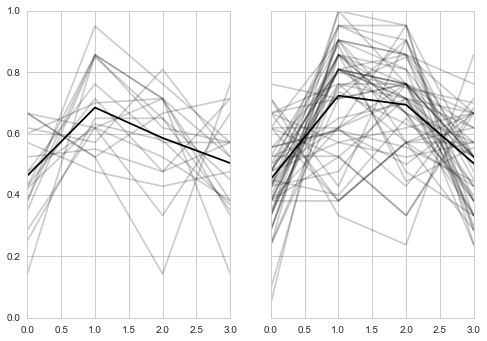

In [29]:
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(np.array([observed_by_type[sid] for sid in sset_opt]).transpose(), color='black', alpha=.2)
ax[0].plot(np.array([observed_by_type[sid] for sid in sset_opt]).mean(axis=0), color='black')
ax[1].plot(np.array([observed_by_type[sid] for sid in sset_norm]).transpose(), color='black', alpha=.2)
ax[1].plot(np.array([observed_by_type[sid] for sid in sset_norm]).mean(axis=0), color='black')
for axi in ax:
    axi.set_ylim(0, 1)
plt.show()

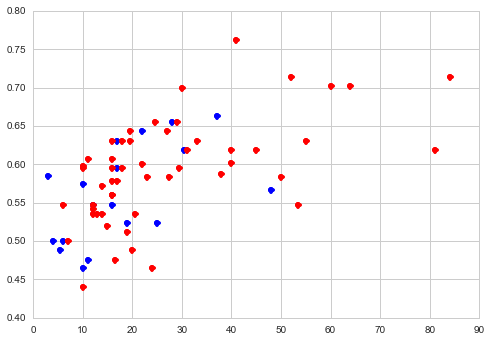

In [148]:
arr_opt = np.array([[np.mean(data[data.subject==sid].choice), np.median(data[data.subject==sid].samplesize)] \
                     for sid in sset_opt])

arr_norm = np.array([[np.mean(data[data.subject==sid].choice), np.median(data[data.subject==sid].samplesize)] \
                     for sid in sset_norm])


plt.plot(arr_opt[:,1], arr_opt[:,0], 'o', color='blue')
plt.plot(arr_norm[:,1], arr_norm[:,0], 'o', color='red')

In [185]:
arr = []
for x in arr_opt:
    arr.append(['optional', x[0], x[1]])
    
for x in arr_norm:
    arr.append(['normal', x[0], x[1]])
    
df = pd.DataFrame(arr, columns=['stoprule', 'acc', 'samplesize'])
df['eff'] = df['acc']/df['samplesize']

In [186]:
import seaborn as sns

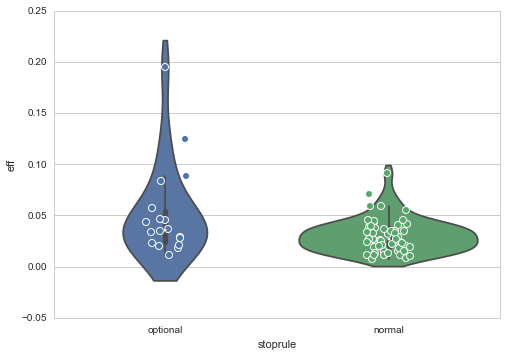

In [187]:
sns.violinplot(x='stoprule', y='eff', data=df, cut=True, alpha=.1)
sns.stripplot(x='stoprule', y='eff', data=df, jitter=True)